# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/ealaxi/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
import pandas as pd
import numpy as np 

data = pd.read_csv('data.csv', nrows = 100000)
data.head()
#outcome would be isFraud
#features: step, tupe, amount,oldbalance,newbalance,oldbalancedest,newbalancedest, nameDest

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### What is the distribution of the outcome? 

<Axes: xlabel='isFraud'>

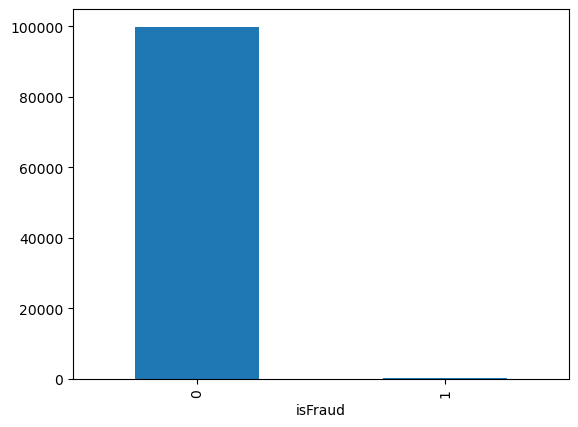

In [2]:
outcome = data['isFraud'].value_counts()

outcome.plot(kind = 'bar', xlabel='isFraud')

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [3]:
# the nameOrig is the target person to act and there's not a name ith more than 1 in count, so i believe it'll not
# be useful to predict since there's not a pattern or high occurence there, so i'll drop 

# also, isFlaggedFraud doesnt flag really anything, so doest look that'll add anything to the forecasting

# to end, the nameDest has some values that call attention to but ill drop it for 2 reason: 1 doesnt mean that just
# have many transactions that arent necesarily fraudulent, then it'll be plenty of work and would add a lot of 
# column if used get dummies. probably we'll loose some info, but i prefer to drop it

data.drop(['nameOrig','nameDest','isFlaggedFraud'], axis = 1, inplace = True)

In [4]:
# lets deal with object variables: type and name dest

#type has 6 values. i'll create dummies for each and drop the original columns
typedummies = pd.get_dummies(data['type'], prefix = '').astype(int)
data = pd.concat([data, typedummies], axis = 1)
data.drop('type', axis = 1, inplace = True)
data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,_CASH_IN,_CASH_OUT,_DEBIT,_PAYMENT,_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


In [5]:
# deal with step
# 1 = 1 hour of time, 9 = 9 hours of time
# since time is a continuous variable ill normalize it
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['step_normalized'] = scaler.fit_transform(data[['step']])
data.drop('step',axis=1,inplace=True)

In [13]:
# choose to oversample to increase samples of the minorty class
from sklearn.utils import resample

nofraud = data[data['isFraud'] == 0]
fraud = data[data['isFraud'] == 1]

fraud_oversampled = resample(data,
                               replace = True,
                               n_samples = len(nofraud),
                               random_state = 0)

fraud = pd.concat([nofraud, fraud_oversampled])
fraud.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,_CASH_IN,_CASH_OUT,_DEBIT,_PAYMENT,_TRANSFER,step_normalized
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0,0.0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0,0.0
5,7817.71,53860.0,46042.29,0.0,0.0,0,0,0,0,1,0,0.0
6,7107.77,183195.0,176087.23,0.0,0.0,0,0,0,0,1,0,0.0


### Run a logisitc regression classifier and evaluate its accuracy.

In [18]:
# setting it
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

feat = fraud.drop('isFraud', axis=1)
target = fraud['isFraud']

x_train, x_test, y_train, y_test = train_test_split(feat, target, random_state=1)

In [21]:
#training and scoring it
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
logreg.score(x_test,y_test)

0.9997196748227944

### Now pick a model of your choice and evaluate its accuracy.

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.9993592567378159

### Which model worked better and how do you know?

In [8]:
# not much of a difference but logistic is still a very very little better

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.